# Runtime Cythonize in QuTiP

![QuTiP logo](./images/qutip_logo-sml.png)

## Prepared for EuroSciPy 2019

![EuroSciPy_logo](./images/EuroSciPy_logo-sml.png)

Alex Pitchford (alex.pitchford@gmail.com)

## Ordinary differential equation solver

of the form

$$ \frac{\textrm{d} x}{\textrm{d} t} = L(t) \; x $$

* $x$ -- vector:
  - state $\newcommand{\ket}[1]{\left|{#1}\right\rangle} \ket{\psi}$ 
  - or vectorised density matrix $\vec{\rho}$

* or $x$ -- matrix:
  - unitary transformation $U$ 
  - or dynamical map $M$

* and $L$ -- sparse matrix that drives the dynamics.
  - In Python these are `Qobj`
  - wrapper to `fast_csr_matrix` -- custom to QuTiP.



### Time dependent dynamics generator

$$ L(t) = L_0 + g_1(t) \, L_1 + g_2(t) \, L_2 + \ldots $$

 * $L(t)$ defined in Python as list of matrices 
 * and (optionally) time-dependent functions

```
L = [L0, [L1, g1], [L2, g2] ....]
```

 * `L` -- `Qobj`
 * `g` -- Python function, e.g. `def g(t, args): return np.cos(args['w']*t)`
 * or string e.g. `"cos(w*t)"`


### Function vs string type time-dependence

| Python function | string type |
| :-: | :-: |
| Python interpreter | Compiled C++ |
| slower execution | Compile time overhead |

*Note:* C++ compiler required at runtime for string type. Non-standard in MS Windows

### String type compilation

1. Dynamic generation of Cython code `.pyx` file
 - right hand side of ODE `cqobjevo_compiled_coeff_<hash>.pyx`
2. Dynamic Python to import time-dependent `QobjEvo`
 - `exec(compile('from ' + filename + ' import CompiledStrCoeff, locals()))`
 - Triggers compilation
3. Temporary file `.pyx` deleted
4. Compiled C++ time-dependent `QobjEvo` can be reused

## Example - control coupled qubits

![quant_optim_ctrl](./images/quant_optim_ctrl.png)



### Unitary dynamics - Schrödinger's equation

$$ \frac{\textrm{d} \ket{\psi}}{\textrm{d} t} = -\textrm{i} \, H(t) \, \ket{\psi} $$

$H(t)$ -- combined Hamiltonian of the system

$$ H(t) = \omega_1 \, H_{\textrm{d}}^{(1)} + \omega_2 \, H_{\textrm{d}}^{(2)} + \omega_{\textrm{i}} \, H_{\textrm{i}} + g_1(t) \, H_{\textrm{c}}^{(1)} + g_2(t) \, H_{\textrm{c}}^{(2)} $$


In [2]:
# Imports and utility functions

import time
import numpy as np
import matplotlib.pyplot as plt
from qutip.sesolve import sesolve
from qutip.solver import Options, solver_safe
from qutip import sigmax, sigmay, sigmaz, identity, tensor, basis, Bloch

def timing_val(func):
    def wrapper(*arg, **kw):
        '''source: http://www.daniweb.com/code/snippet368.html'''
        t1 = time.time()
        res = func(*arg, **kw)
        t2 = time.time()
        return res, (t2 - t1), func.__name__
    return wrapper

def plot_exp(tlist, expects, lbls, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, e in enumerate(expects):#

        ax.plot(tlist, e, label=lbls[i])

    ax.set_xlabel(r"$t$")
    ax.set_title(title)
    ax.legend()

You are in the installation directory. Change directories before running QuTiP.


### Time dependent control functions

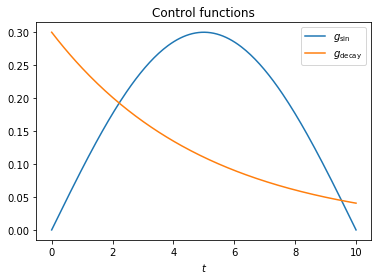

In [3]:
def g_sine(t, args):
    return args['A_s']*np.sin(args['w_s']*t)

def g_decay(t, args):
    return args['A_d']*np.exp(-t/args['t_d'])

g_sine_str = "A_s*sin(w_s*t)"
g_decay_str = "A_d*exp(-t/t_d)"

t_tot = 10.0

w_1 = 0.3
w_2 = 0.3
w_i = 0.02

A_s = 0.3
A_d = 0.3
w_s = np.pi/t_tot
t_d = 5.0

tlist = np.linspace(0.0, t_tot, 200)

args = {'A_s': A_s, 'A_d': A_s, 'w_s': w_s, 't_d': t_d}

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tlist, g_sine(tlist, args), label=r"$g_{\rm{sin}}$") #$")
ax.plot(tlist, g_decay(tlist, args), label=r"$g_{\rm{decay}}$")
ax.set_xlabel(r"$t$")
ax.set_title("Control functions")
ax.legend()

### Hamiltonians, initial state and measurements


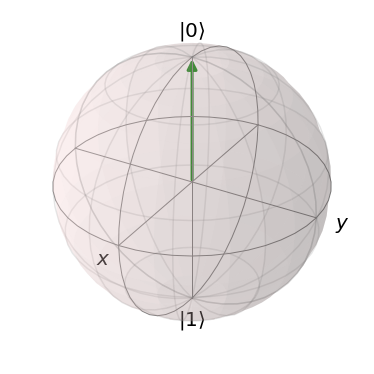

In [4]:
Id2 = identity(2)
Sz1 = tensor(sigmaz(), Id2)
Sz2 = tensor(Id2, sigmaz())
Sx1 = tensor(sigmax(), Id2)
Sy1 = tensor(sigmay(), Id2)
Sx2 = tensor(Id2, sigmax())
Sy2 = tensor(Id2, sigmay())

H_d1 = w_1*Sz1
H_d2 = w_2*Sz2
H_c1 = Sx1
H_c2 = Sy2
H_i = w_i*tensor(sigmaz(), sigmaz())

H_func_type = [H_d1, H_d2, [H_c1, g_sine], [H_c2, g_decay], H_i]
H_str_type = [H_d1, H_d2, [H_c1, g_sine_str], [H_c2, g_decay_str], H_i]

up_state = basis(2, 0)
b = Bloch()
b.add_states(up_state)
b.show()

init_state = tensor(up_state, up_state)

meas = [Sz1, Sx1, Sz2, Sx2]

### Solving the dynamics

In [5]:
@timing_val
def repeat_solve(H, init_state, tlist, num_reps=1,
                 e_ops=None, args=None, options=None):

    if options is None:
        options = Options()

    out = sesolve(H, init_state, tlist,
              e_ops=meas, args=args, options=options)

    if num_reps > 1:
        options.rhs_reuse = True
        tl = np.array([0, tlist[-1]])
        for i in range(num_reps - 1):
            sesolve(H, init_state, tl,
                          e_ops=meas, args=args, options=options)

    return out

### Function type

1 execution of func type took 0.04008340835571289 seconds.


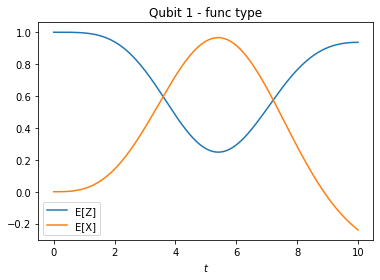

In [9]:
n_reps = 1
out, t_func, fname = repeat_solve(H_func_type, init_state, tlist, num_reps=n_reps,
                                  e_ops=meas, args=args)
print("{} execution of func type took {} seconds.".format(n_reps, t_func))

# Plot qubit 1 expectations
plot_exp(tlist, out.expect[:2], lbls=["E[Z]", "E[X]"],
         title="Qubit 1 - func type")

### String type

1 execution of string type took 0.03155088424682617 seconds.


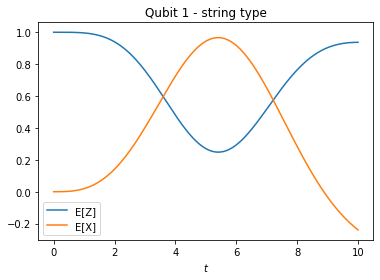

In [8]:
n_reps = 1
out, t_func, fname = repeat_solve(H_str_type, init_state, tlist, num_reps=n_reps,
                                  e_ops=meas, args=args)
print("{} execution of string type took {} seconds.".format(n_reps, t_func))

# Plot qubit 1 expectations
plot_exp(tlist, out.expect[:2], lbls=["E[Z]", "E[X]"],
         title="Qubit 1 - string type")

## Comparing execution times

2 execution of func type took 0.040526628494262695 seconds.
2 execution of string type took 2.7957499027252197 seconds.
6 execution of func type took 0.03649759292602539 seconds.
6 execution of string type took 2.9504189491271973 seconds.
12 execution of func type took 0.0405573844909668 seconds.
12 execution of string type took 3.0099339485168457 seconds.
24 execution of func type took 0.05051064491271973 seconds.
24 execution of string type took 2.9982755184173584 seconds.


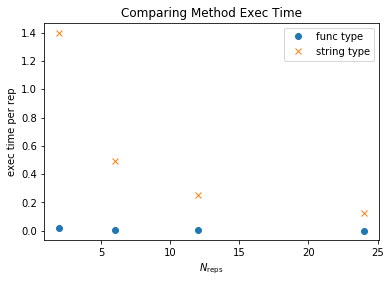

In [7]:
n_rep_list = [1, 2, 5, 10, 20] #, 100] #, 1000, 20000, 100000]
# n_rep_list = [100, 1000, 20000, 100000, 500000]
t_per_exec_f = []
t_per_exec_s = []

H_zero = H_i*0.0

for i, n_reps in enumerate(n_rep_list):
    out, t_func, fname = repeat_solve(H_func_type, init_state, tlist,
                                      num_reps=n_reps,
                                      e_ops=meas, args=args)

    t_per_exec_f.append(t_func / n_reps)
    #print("{} execution of func type took {} seconds.".format(n_reps, t_func))

    # twisted method of making the code change to force new hash and
    # hence recompile
    key = 'nreps{}'.format(i)
    args[key] = n_reps
    H = list(H_str_type)
    H.append([H_zero, key])
    out, t_func, fname = repeat_solve(H, init_state, tlist,
                                      num_reps=n_reps,
                                      e_ops=meas, args=args)
    #print("{} execution of string type took {} seconds.".format(n_reps, t_func))
    t_per_exec_s.append(t_func / n_reps)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_rep_list, t_per_exec_f, 'o', label="func type")
ax.plot(n_rep_list, t_per_exec_s, 'x', label="string type")
ax.set_xlabel(r"$N_{\rm{reps}}$")
ax.set_ylabel("exec time per rep")
ax.set_title("Comparing Method Exec Time")
ax.legend()

1000 execution of func type took 0.863217830657959 seconds.
1000 execution of string type took 3.4494686126708984 seconds.
5000 execution of func type took 4.137576103210449 seconds.
5000 execution of string type took 5.2260167598724365 seconds.
10000 execution of func type took 8.4768385887146 seconds.
10000 execution of string type took 7.882353067398071 seconds.
15000 execution of func type took 14.995506763458252 seconds.
15000 execution of string type took 7.593310832977295 seconds.
20000 execution of func type took 19.863017559051514 seconds.
20000 execution of string type took 13.951071977615356 seconds.
50000 execution of func type took 44.31708788871765 seconds.
50000 execution of string type took 27.833807229995728 seconds.
100000 execution of func type took 88.46810746192932 seconds.
100000 execution of string type took 52.444971323013306 seconds.


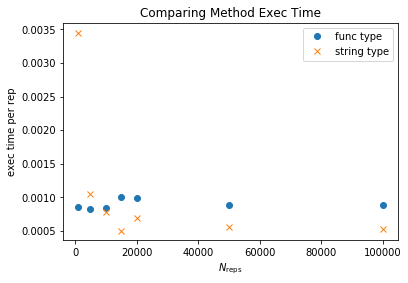

In [8]:
n_rep_list = [1000, 5000, 10000, 15000, 20000, 50000, 100000]
t_per_exec_f = []
t_per_exec_s = []

H_zero = H_i*0.0

for i, n_reps in enumerate(n_rep_list):
    out, t_func, fname = repeat_solve(H_func_type, init_state, tlist,
                                      num_reps=n_reps,
                                      e_ops=meas, args=args)

    t_per_exec_f.append(t_func / n_reps)
    #print("{} execution of func type took {} seconds.".format(n_reps, t_func))

    # twisted method of making the code change to force new hash and
    # hence recompile
    key = 'nreps{}'.format(i)
    args[key] = n_reps
    H = list(H_str_type)
    H.append([H_zero, key])
    out, t_func, fname = repeat_solve(H, init_state, tlist,
                                      num_reps=n_reps,
                                      e_ops=meas, args=args)
    #print("{} execution of string type took {} seconds.".format(n_reps, t_func))
    t_per_exec_s.append(t_func / n_reps)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_rep_list, t_per_exec_f, 'o', label="func type")
ax.plot(n_rep_list, t_per_exec_s, 'x', label="string type")
ax.set_xlabel(r"$N_{\rm{reps}}$")
ax.set_ylabel("exec time per rep")
ax.set_title("Comparing Method Exec Time")
ax.legend()

## Questions

1. Can we do away with the temporary `.pyx` file?
2. Can we do away with runtime compilation all together?
 - and still have arbitrary time dependence at compiled code speed